## GT대비 mediapipe complexity별 정확도

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import io

import glob
import pandas as pd

import cv2
import os
import re

import time
import mediapipe as mp

gt로 사용할 데이터셋 시작과 끝 frame 2개 업로드
(이는, frame별로 json이 존재하여 합치기 위해 처리하는 과정)

In [22]:
# ground_truth 경로 설정
gt_base_path = './data/ground_truth/'
gt_json_path = ''  # 전역 변수
gt_json_name = []
# 디렉터리 내 모든 폴더명 수집 함수
def get_all_folders(path):
    try:
        folder_names = [
            name for name in os.listdir(path) 
            if os.path.isdir(os.path.join(path, name))
        ]
        print("Folders found in", path)
        return [os.path.join(path, folder) for folder in folder_names]
    except FileNotFoundError:
        print(f"The path '{path}' does not exist.")
        return []
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return []

# 업로드된 파일의 경로를 저장하는 함수
def store_gt_json_path(uploaded_files):
    global gt_json_path  # 전역 변수로 선언
    global gt_json_name
    for file_info in uploaded_files.values():
        filename = file_info['metadata']['name']  # 파일명 추출
        folders = get_all_folders(gt_base_path)  # 폴더 탐색
        gt_json_name.append(filename)

        for folder in folders:
            if filename in os.listdir(folder):
                gt_json_path = folder  # 경로 저장
                if len(gt_json_name) == 2 : 
                    print(f"gt_json_path set to: {gt_json_path}")
                    print(f"gt_json_name set to: {gt_json_name}")
                    return
    
# 업로드 이벤트 핸들러
def handle_file_upload(change):
    print("Upload complete. Processing...")
    store_gt_json_path(change['new'])

# 파일 업로드 위젯 생성
upload_widget = widgets.FileUpload(accept='.json', multiple=True)
upload_widget.observe(handle_file_upload, names='value')

# 위젯 표시
display(widgets.VBox([widgets.Label("Upload JSON files to search"), upload_widget]))

Upload complete. Processing...
Folders found in ./data/ground_truth/
Folders found in ./data/ground_truth/
gt_json_path set to: ./data/ground_truth/vid5
gt_json_name set to: ['20200616_General_005_DOS_P_F20_MM_003_2754.json', '20200616_General_005_DOS_P_F20_MM_003_2821.json']


frame별로 있는 json을 하나의 json으로 통합

In [23]:
# 경로 확인
print(f"gt_json_path: {gt_json_path}")

# 주어진 폴더 내 모든 JSON 파일 경로 가져오기
def get_json_files_from_folder(folder_path):
    json_files = glob.glob(os.path.join(folder_path, "*.json"))
    if not json_files:
        raise FileNotFoundError(f"No JSON files found in {folder_path}")
    return json_files

# 첫 번째 JSON의 'categories.keypoints' 가져오기 함수
def get_keypoints_from_first_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data.get('categories', {}).get('keypoints', [])

# 모든 JSON의 'annotations.points'를 수집하고 frame으로 병합하는 함수
def collect_all_frames(json_files):
    frames = []
    for frame_idx, path in enumerate(json_files):
        with open(path, 'r') as f:
            data = json.load(f)
            annotations = data.get('annotations', [])
            for annotation in annotations:
                if 'points' in annotation:
                    frames.append({
                        "frame": frame_idx,
                        "points": annotation['points']
                    })
    return frames

# 통합된 JSON 생성 함수
def create_merged_json(keypoints, frames):
    merged_data = {
        "categories": {
            "keypoints": keypoints
        },
        "annotations": frames  # frames가 포함된 annotations
    }
    return merged_data

# 결과 JSON을 저장하는 함수
def save_merged_json(output_path, merged_data):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    with open(output_path, 'w') as f:
        json.dump(merged_data, f, indent=2)
    print(f"Merged JSON saved to {output_path}")

# 통합 프로세스 실행 함수
def merge_json_files_from_folder(folder_path, output_path):
    json_files = get_json_files_from_folder(folder_path)
    keypoints = get_keypoints_from_first_json(json_files[0])
    frames = collect_all_frames(json_files)
    merged_data = create_merged_json(keypoints, frames)
    save_merged_json(output_path, merged_data)

# 마지막 폴더명을 추출하여 출력 경로 설정
last_json_folder = os.path.basename(gt_json_path)
merge_json_output_path = f'./data/ground_truth/merge_json/{last_json_folder}.json'

print(f"Output Path: {merge_json_output_path}")

# 병합 실행
merge_json_files_from_folder(gt_json_path, merge_json_output_path)


gt_json_path: ./data/ground_truth/vid5
Output Path: ./data/ground_truth/merge_json/vid5.json
Merged JSON saved to ./data/ground_truth/merge_json/vid5.json


해당 frame별 이미지 기반으로 mediapipe complexity별 json 저장

In [28]:
import mediapipe as mp
import time


key_point_string = ["head","right_shoulder","left_shoulder",
                    "right_elbow","left_elbow","right_wrist","left_wrist",
                    "right_hip","left_hip","right_knee","left_knee",
                    "right_ankle", "left_ankle"]

string_match_index = [8,12,11,
                      14,13,16,15,
                      24,23,26,25,
                      32,31]

num_joint = len(key_point_string)

image_start_name = gt_json_path + '/' + gt_json_name[0]
image_end_name = gt_json_path + '/' + gt_json_name[1]

# 숫자와 공통된 이름을 추출하는 함수
def extract_name_and_number(filename):
    match = re.match(r'(.+?)_(\d+)\.json$', filename)  # 공통된 이름과 마지막 숫자 추출
    if match:
        common_name = match.group(1)  # 공통된 이름 추출
        number = int(match.group(2))  # 숫자 추출
        return common_name, number
    else:
        return None, None  # 매칭되지 않을 경우
    
# 시작과 끝 숫자 추출
common_name, start_num = extract_name_and_number(gt_json_name[0])
common_name, end_num = extract_name_and_number(gt_json_name[1])

# 이미지 처리 함수
def compelxity_mp_on_images(complexity, start, end, image_folder, image_name= common_name):
    start_time = time.time()
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
        model_complexity=complexity
    )

    none_frame = []
    cvPoseLandMark = [[[], [], [], []] for _ in range(len(string_match_index))]
    start_time=time.time()
    # 이미지 처리 반복문
    for frame in range(start,end+1):
        image_path = f"{image_folder}/{image_name}_{str(frame).zfill(4)}.jpg" 
        # image_path = '2024-09-27_14h28m51s_frame0.jpg'
        # print(image_path)
        if not os.path.exists(image_path):
            print(f"{image_path} does not exist. Skipping...")
            none_frame.append(frame)
            continue

        image = cv2.imread(image_path)
        h, w, c = image.shape  # 이미지 크기 추출

        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.pose_landmarks is None:
            for i in range(num_joint):
                for j in range(4):
                    cvPoseLandMark[i][j].append(0)
            none_frame.append(frame)
        else:
            for i in range(num_joint):
                cvPoseLandMark[i][0].append(round(results.pose_landmarks.landmark[string_match_index[i]].x * w))
                cvPoseLandMark[i][1].append(round(results.pose_landmarks.landmark[string_match_index[i]].y * h))
                cvPoseLandMark[i][2].append(round(results.pose_world_landmarks.landmark[string_match_index[i]].z))
                cvPoseLandMark[i][3].append(round(results.pose_world_landmarks.landmark[string_match_index[i]].x))

    return cvPoseLandMark, none_frame, end - start + 1, w, h, time.time()-start_time
# 결과를 저장하는 함수
def save_keypoints_and_frames(complexity, keypoints, points_data, output_file):
    data = {
        "categories": {
            "keypoints": keypoints
        },
        "annotations": []
    }

    for frame_idx, _ in enumerate(points_data[0][0]):
        frame_data = {
            "frame": frame_idx,
            "points": [
                coord for i in range(num_joint)
                for coord in [points_data[i][0][frame_idx], points_data[i][1][frame_idx], complexity]
            ]
        }
        data["annotations"].append(frame_data)

    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    with open(output_file, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"Saved data to {output_file}")

# 이미지 경로와 출력 경로 설정
image_folder = gt_json_path
mp_output_paths = []
run_times = []
# 복잡도별 이미지 처리 및 결과 저장
for i in range(3):
    mp_output_path = f"./data/complexity_data/{last_json_folder}_{i}.json"
    mp_output_paths.append(mp_output_path)

    # 이미지 처리 수행
    cv, none, frame_count, w, h, run_time = compelxity_mp_on_images(i, start_num, end_num, image_folder)
    run_times.append(run_time)
    # 결과 저장
    save_keypoints_and_frames(i, key_point_string, cv, mp_output_path)

complexity_time = {
    "0" : run_times[0],
    "1" : run_times[1],
    "2" : run_times[2],
    "frame" : frame_count
}

def save_complexity_time(complexity_time, last_json_folder):
    # Define the output path
    output_file = f"./data/result/{last_json_folder}/time.json"
    
    # Ensure the output directory exists
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    # Save the dictionary as a JSON file
    with open(output_file, 'w') as f:
        json.dump(complexity_time, f, indent=2)
    
    print(f"Saved complexity_time to {output_file}")

# Call the save function after the processing loop
save_complexity_time(complexity_time, last_json_folder)


Saved data to ./data/complexity_data/vid5_0.json
Saved data to ./data/complexity_data/vid5_1.json
Saved data to ./data/complexity_data/vid5_2.json
Saved complexity_time to ./data/result/vid5/time.json


gt json을 mediapipe와 동일한 keypoints만 남기고 순서변경해서 재저장

In [29]:
# Mediapipe keypoints 정의 (남길 keypoints)
mediapipe_keypoints = [
    "head", "right_shoulder", "left_shoulder", "right_elbow", "left_elbow",
    "right_wrist", "left_wrist", "right_hip", "left_hip", "right_knee", 
    "left_knee", "right_ankle", "left_ankle"
]

# GT JSON keypoints 정의 (기존 순서)
gt_keypoints = [
    "head", "neck", "chest", "right_shoulder", "left_shoulder", 
    "right_elbow", "left_elbow", "right_wrist", "left_wrist", 
    "hip", "right_hip", "left_hip", "right_knee", "left_knee", 
    "right_ankle", "left_ankle"
]

# GT JSON의 annotations를 Mediapipe keypoints에 맞게 재정렬하는 함수
def reorder_annotations(annotations, gt_keys, mediapipe_keys):
    reordered_annotations = []

    for annotation in annotations:
        frame = annotation["frame"]
        points = annotation["points"]

        # GT 순서의 keypoints에 맞게 재배열된 points 저장
        reordered_points = []
        for key in mediapipe_keys:
            if key in gt_keys:
                idx = gt_keys.index(key) * 3  # x, y, z 인덱스 계산
                reordered_points.extend(points[idx:idx+3])
            else:
                # Mediapipe에 없는 keypoint는 [0, 0, 0]으로 채움
                reordered_points.extend([0, 0, 0])

        # 재정렬된 데이터를 annotations에 추가
        reordered_annotations.append({
            "frame": frame,
            "points": reordered_points
        })

    return reordered_annotations

# GT JSON을 수정하는 함수
def update_gt_json(input_file, output_file, mediapipe_keys, gt_keys):
    # 기존 GT JSON 파일 읽기
    with open(input_file, 'r') as f:
        data = json.load(f)

    # 기존 annotations 재정렬
    reordered_annotations = reorder_annotations(
        data["annotations"], gt_keys, mediapipe_keys
    )

    # JSON 업데이트: keypoints와 annotations 수정
    updated_data = {
        "categories": {
            "keypoints": mediapipe_keys  # Mediapipe keypoints로 업데이트
        },
        "annotations": reordered_annotations
    }

    # 저장할 디렉터리 생성
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    # 수정된 JSON 저장
    with open(output_file, 'w') as f:
        json.dump(updated_data, f, indent=2)
    print(f"Updated GT JSON saved to {output_file}")

input_file = merge_json_output_path
update_gt_output_file = f'./data/ground_truth/merge_json/{last_json_folder}_updated.json'

# GT JSON 수정 실행
update_gt_json(input_file, update_gt_output_file, mediapipe_keypoints, gt_keypoints)

Updated GT JSON saved to ./data/ground_truth/merge_json/vid5_updated.json


complexity별 gt와 비교

Skipping frame 68 for Complexity_0 - No prediction data.
Skipping frame 68 for Complexity_1 - No prediction data.
Skipping frame 68 for Complexity_2 - No prediction data.


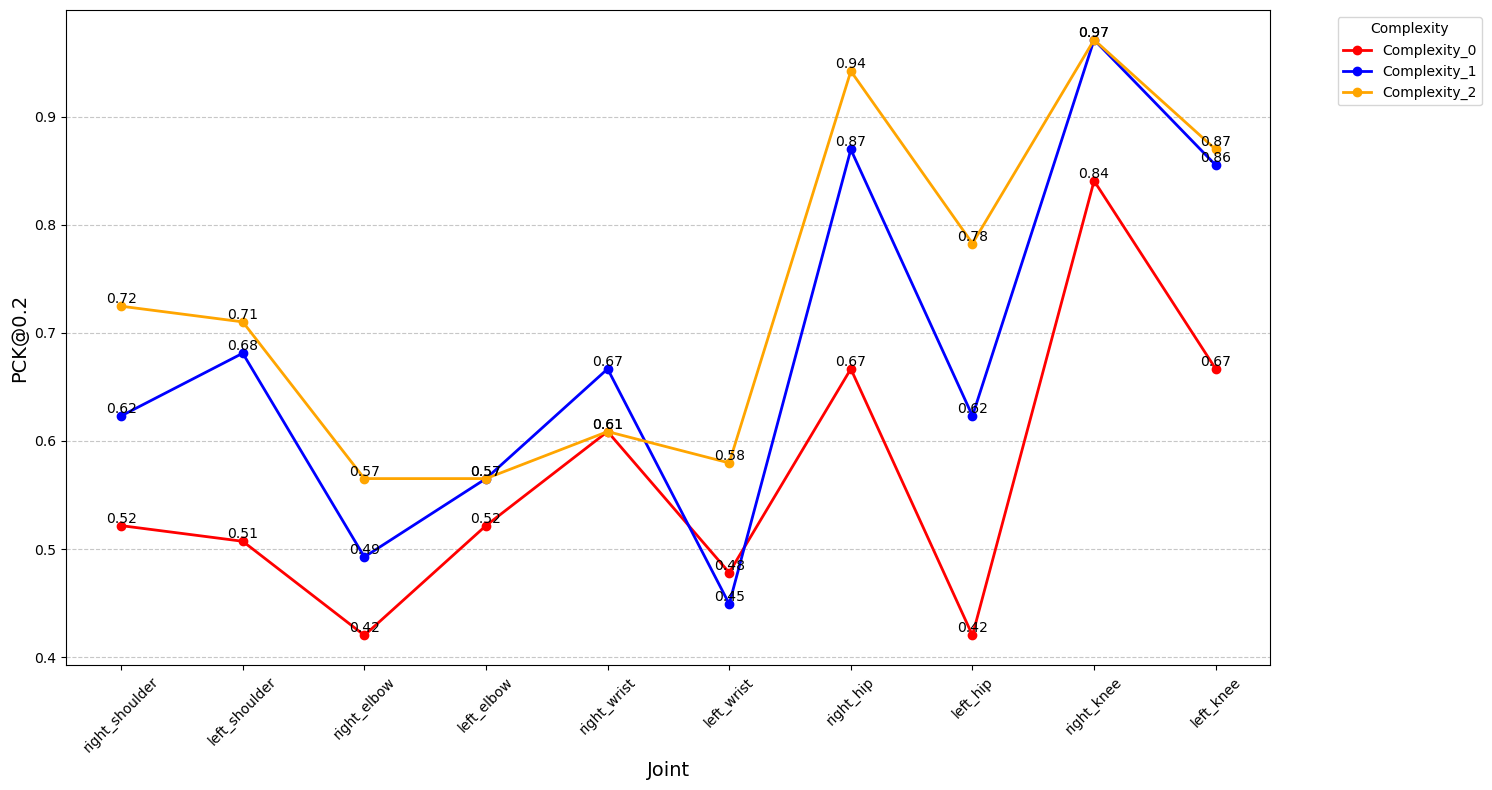

save png : ./data/result/vid5/joint_pck_comparison.png
save json : ./data/result/vid5/pck_results.json


In [30]:
def load_json(file_path):
    """JSON 파일을 읽어 딕셔너리로 반환합니다."""
    with open(file_path, 'r') as f:
        return json.load(f)
    
def save_to_json(data, file_path):
    """데이터를 JSON 파일로 저장합니다."""
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)

def extract_keypoints(data, frame_index):
    """주어진 프레임에서 키포인트 좌표를 추출합니다."""
    frame_data = data['annotations'][frame_index]['points']
    keypoints = np.array(frame_data).reshape(-1, 3)[:, :2]  # (x, y) 좌표만 추출
    return keypoints

def calculate_midpoint(point1, point2):
    """두 점의 중점을 계산합니다."""
    return (np.array(point1) + np.array(point2)) / 2

def calculate_torso_length(keypoints):
    """엉덩이와 어깨의 중점 간 거리를 계산합니다."""
    hip_mid = calculate_midpoint(keypoints[7], keypoints[8])  # 좌우 엉덩이
    shoulder_mid = calculate_midpoint(keypoints[1], keypoints[2])  # 좌우 어깨
    return np.linalg.norm(hip_mid - shoulder_mid)

def calculate_joint_pck(gt_keypoints, pred_keypoints, threshold):
    """프레임별 각 관절의 PCK를 계산합니다."""
    return [
        1 if np.linalg.norm(gt_keypoints[i] - pred_keypoints[i]) <= threshold else 0
        for i in range(len(gt_keypoints))
    ]

def process_files(gt_json_path, pred_json_paths):
    """GT와 예측 데이터를 처리해 모든 프레임의 PCK를 계산하고 그래프로 표시합니다."""
    gt_data = load_json(gt_json_path)
    total_frames = len(gt_data['annotations'])  # GT 파일의 총 프레임 수
    keypoints = gt_data['categories']['keypoints']  # 모든 관절 포함

    results = []

    # 각 복잡도별 예측 데이터 처리
    for i, pred_path in enumerate(pred_json_paths):
        pred_data = load_json(pred_path)
        joint_pck_sums = np.zeros(len(keypoints))

        # 예측 데이터의 총 프레임 수 확인
        pred_total_frames = len(pred_data['annotations'])

        for frame_index in range(total_frames):
            if frame_index >= pred_total_frames:
                print(f"Skipping frame {frame_index} for Complexity_{i} - No prediction data.")
                continue  # 예측 데이터가 부족한 경우 건너뜀

            gt_keypoints = extract_keypoints(gt_data, frame_index)
            pred_keypoints = extract_keypoints(pred_data, frame_index)

            torso_length = calculate_torso_length(gt_keypoints)
            threshold = 0.2 * torso_length

            joint_pcks = calculate_joint_pck(gt_keypoints, pred_keypoints, threshold)
            joint_pck_sums += np.array(joint_pcks)

        # 평균 PCK 계산
        joint_pck_means = joint_pck_sums / total_frames
        results.append({
            'Complexity': f'Complexity_{i}',
            **dict(zip(keypoints, joint_pck_means))
        })

    # 데이터프레임으로 변환
    df = pd.DataFrame(results)

    # 'head' 관절 제거 (시각화에서만)
    joints_to_plot = [k for k in keypoints if k not in ['head', 'left_ankle', 'right_ankle']]

    # 그래프 생성 및 설정
    fig, ax = plt.subplots(figsize=(15, 8))
    colors = ['red', 'blue', 'orange']

    # 각 복잡도별로 꺾은선 그래프 생성
    for idx, row in df.iterrows():
        y_values = [row[joint] for joint in joints_to_plot]
        ax.plot(
            joints_to_plot,  # x축 관절 이름
            y_values,  # PCK 값
            marker='o',
            color=colors[idx],  # 복잡도에 따른 색상
            label=row['Complexity'],
            linewidth=2
        )

        # 데이터 포인트 위에 값 표시
        for x, y in zip(joints_to_plot, y_values):
            ax.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=10)

    ax.set_xlabel('Joint', fontsize=14)
    ax.set_ylabel('PCK@0.2', fontsize=14)
    ax.legend(title='Complexity', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # 해당 경로의 폴더가 없으면 생성
    os.makedirs(f'./data/result/{last_json_folder}', exist_ok=True)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'./data/result/{last_json_folder}/joint_pck_comparison.png')
    plt.show()

    # 결과를 JSON으로 저장
    save_to_json(results, f'./data/result/{last_json_folder}/pck_results.json')
    print(f"save png : ./data/result/{last_json_folder}/joint_pck_comparison.png")
    print(f"save json : ./data/result/{last_json_folder}/pck_results.json")

# 파일 경로 설정
gt_json_path = update_gt_output_file
pred_json_paths = mp_output_paths
# PCK 계산 실행
process_files(gt_json_path, pred_json_paths)


여러 json 평균 gt 비교

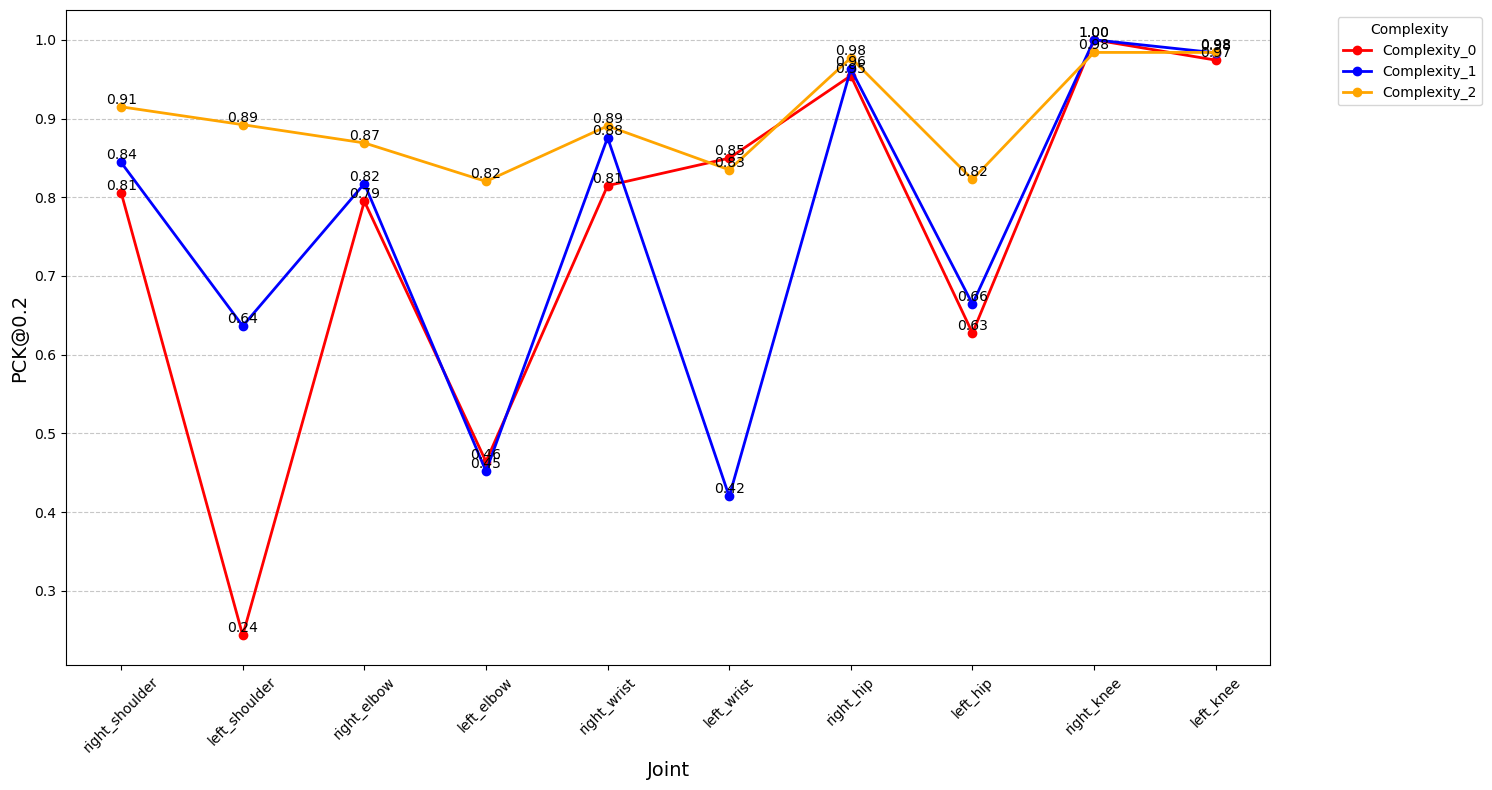

Saved graph as: ./data/result/aggregated_joint_pck_comparison.png


In [31]:
# JSON 파일 로드 함수
def load_json(file_path):
    """JSON 파일을 읽어 딕셔너리로 반환합니다."""
    with open(file_path, 'r') as f:
        return json.load(f)

# PCK 결과를 시각화하는 함수
def plot_pck_results(pck_results_path):
    """JSON 파일에서 PCK 데이터를 로드하고 그래프로 시각화합니다."""
    # JSON 파일 로드
    pck_data = load_json(pck_results_path)

    # Pandas DataFrame으로 변환
    df = pd.DataFrame(pck_data)

    # 'head', 'left_ankle', 'right_ankle' 관절 제거 (시각화에서만)
    joints_to_plot = [
        k for k in df.columns if k not in ['Complexity', 'head', 'left_ankle', 'right_ankle']
    ]

    # 그래프 생성 및 설정
    fig, ax = plt.subplots(figsize=(15, 8))
    colors = ['red', 'blue', 'orange']

    # 각 복잡도별로 꺾은선 그래프 생성
    for idx, row in df.iterrows():
        y_values = [row[joint] for joint in joints_to_plot]
        ax.plot(
            joints_to_plot,  # x축에 표시할 관절 이름들
            y_values,  # 해당 관절의 PCK 값
            marker='o',
            color=colors[idx],  # 복잡도에 따른 색상
            label=row['Complexity'],
            linewidth=2
        )

        # 데이터 포인트 위에 값 표시
        for x, y in zip(joints_to_plot, y_values):
            ax.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=10)

    # 그래프 레이블 및 설정
    ax.set_xlabel('Joint', fontsize=14)
    ax.set_ylabel('PCK@0.2', fontsize=14)
    ax.legend(title='Complexity', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.xticks(rotation=45)
    plt.tight_layout()

    # 결과 저장
    output_png = pck_results_path.replace("pck_results.json", "joint_pck_comparison.png")
    plt.savefig(output_png)
    plt.show()

    print(f"Saved graph as: {output_png}")

# PCK JSON 파일 경로 설정
pck_results_path = "./data/result/aggregated_pck_results.json"

# 그래프 그리기 실행
plot_pck_results(pck_results_path)

mediapipe complexity별 시간

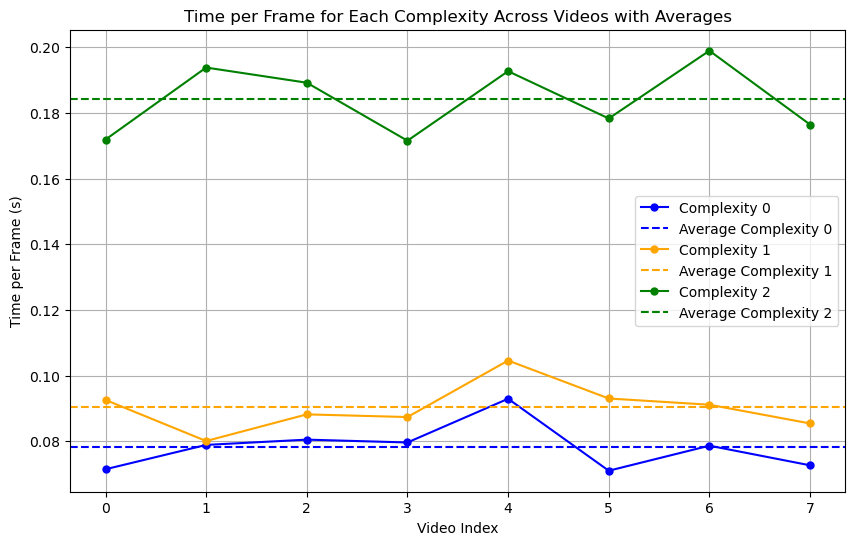

In [32]:
# Directory containing the result folders
root_dir = "./data/result"

complexity_times_per_frame = {0: [], 1: [], 2: []}
# Traverse all folders and read time.json files
for folder_name in os.listdir(root_dir):
    time_json_path = os.path.join(root_dir, folder_name, "time.json")
    if os.path.exists(time_json_path):
        with open(time_json_path, 'r') as f:
            data = json.load(f)
            for i in range(3):
                if data["frame"] > 0:  # Avoid division by zero or negative frames
                    time_per_frame = data[str(i)] / data["frame"]
                    complexity_times_per_frame[i].append(time_per_frame)

# Calculate the average time per frame for each complexity
average_times_per_frame = {
    i: np.mean(complexity_times_per_frame[i]) for i in range(3)
}

# Plotting the time per frame for each complexity as line graphs
plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green']

for i in range(3):
    # Plot individual time per frame data
    plt.plot(
        range(len(complexity_times_per_frame[i])),
        complexity_times_per_frame[i],
        marker='o', linestyle='-', markersize=5,
        color=colors[i],
        label=f'Complexity {i}'
    )
    # Plot average line
    plt.axhline(
        y=average_times_per_frame[i],
        color=colors[i],
        linestyle='--',
        label=f'Average Complexity {i}'
    )

plt.xlabel('Video Index')
plt.ylabel('Time per Frame (s)')
plt.title('Time per Frame for Each Complexity Across Videos with Averages')
plt.legend()
plt.grid(True)
plt.show()

## mediapipe Ensemble model

In [33]:
from tsmoothie.smoother import *
key_point_string = ["head","right_shoulder","left_shoulder",
                    "right_elbow","left_elbow","right_wrist","left_wrist",
                    "right_hip","left_hip","right_knee","left_knee",
                    "right_ankle", "left_ankle"]

string_match_index = [8,12,11,
                      14,13,16,15,
                      24,23,26,25,
                      32,31]

num_joint = len(key_point_string)
eight_step = ["address", "take_away", "half", "top", "down_half", "impact", "follow_through", "finish" ]

# 이미지 처리 함수
def compelxity_mp_on_images(complexity, start, end, image_folder, image_name):
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
        model_complexity=complexity
    )

    none_frame = []
    cvPoseLandMark = [[[], [], [], []] for _ in range(len(string_match_index))]

    # 이미지 처리 반복문
    start_time=time.time()
    for frame in range(start,end+1):
        image_path = f"{image_folder}/{image_name}_{str(frame).zfill(4)}.jpg" 
        # image_path = '2024-09-27_14h28m51s_frame0.jpg'
        # print(image_path)
        if not os.path.exists(image_path):
            print(f"{image_path} does not exist. Skipping...")
            none_frame.append(frame)
            continue
        image = cv2.imread(image_path)
        h, w, c = image.shape  # 이미지 크기 추출

        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.pose_landmarks is None:
            for i in range(num_joint):
                for j in range(4):
                    cvPoseLandMark[i][j].append(0)
            none_frame.append(frame)
        else:
            for i in range(num_joint):
                cvPoseLandMark[i][0].append(round(results.pose_landmarks.landmark[string_match_index[i]].x * w))
                cvPoseLandMark[i][1].append(round(results.pose_landmarks.landmark[string_match_index[i]].y * h))
                cvPoseLandMark[i][2].append(round(results.pose_world_landmarks.landmark[string_match_index[i]].z))
                cvPoseLandMark[i][3].append(round(results.pose_world_landmarks.landmark[string_match_index[i]].x))
    end_time = time.time()-start_time
    
    print(f"{image_folder} complete : {complexity}")
    return cvPoseLandMark, none_frame, end - start + 1, w, h, end_time

def conv_smoothing(video_length: int, PoseLandmark: list[list[list[float]]], cvPoseLandmark: list[list[list[float]]], 
                   width: int, height: int, empty_frame: list[int]) -> None:
    """
    비디오의 포즈 랜드마크 좌표에 대해 컨볼루션 스무딩을 적용.

    Args:
        video_length (int): 전체 비디오의 길이 (프레임 수).
        PoseLandmark (list[list[list[float]]]): 각 관절의 포즈 랜드마크 좌표를 담고 있는 리스트.
        cvPoseLandmark (list[list[list[float]]]): 각 프레임에서의 포즈 랜드마크 좌표를 담고 있는 리스트.
        width (int): 비디오의 폭 (픽셀).
        height (int): 비디오의 높이 (픽셀).
        empty_frame (list[int]): 포즈 랜드마크를 감지하지 못한 프레임 번호 리스트.

    Returns:
        None
    """
    smoother = ConvolutionSmoother(window_len=3, window_type='ones')
    for joint in range(num_joint):
        # if key_point_string[joint] == "left_shoulder" or key_point_string[joint] == "right_shoulder" :
        #     continue
        smoother.smooth(cvPoseLandmark[joint][0])
        low, up = smoother.get_intervals('sigma_interval',n_sigma=3)
        cvPoseLandmark[joint][0] = smoother.smooth_data[0]

        smoother.smooth(cvPoseLandmark[joint][1])
        low, up = smoother.get_intervals('sigma_interval',n_sigma=3)
        cvPoseLandmark[joint][1] = smoother.smooth_data[0]

        smoother.smooth(cvPoseLandmark[joint][2])
        low, up = smoother.get_intervals('sigma_interval',n_sigma=3)
        cvPoseLandmark[joint][2] = smoother.smooth_data[0]

        smoother.smooth(cvPoseLandmark[joint][3])
        low, up = smoother.get_intervals('sigma_interval',n_sigma=3)
        cvPoseLandmark[joint][3] = smoother.smooth_data[0]

    for frame_num in range(video_length):
        for joint in range(num_joint):
            if frame_num not in empty_frame :
                PoseLandmark[joint][0].append(cvPoseLandmark[joint][0][frame_num]/width)
                PoseLandmark[joint][1].append(cvPoseLandmark[joint][1][frame_num]/height)
                PoseLandmark[joint][2].append(cvPoseLandmark[joint][2][frame_num])
                PoseLandmark[joint][3].append(cvPoseLandmark[joint][3][frame_num])
            else :
                for j in range(4) :
                    PoseLandmark[joint][j].append(0)

# 결과를 저장하는 함수
def save_keypoints_and_frames(complexity, keypoints, points_data, output_file):
    data = {
        "categories": {
            "keypoints": keypoints
        },
        "annotations": []
    }

    for frame_idx, _ in enumerate(points_data[0][0]):
        frame_data = {
            "frame": frame_idx,
            "points": [
                coord for i in range(num_joint)
                for coord in [points_data[i][0][frame_idx], points_data[i][1][frame_idx], complexity]
            ]
        }
        data["annotations"].append(frame_data)

    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    with open(output_file, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"Saved data to {output_file}")

def get_index_mp(joint_name: str) -> int:
    """
    주어진 관절 이름에 대한 mediapipe 인덱스를 반환.

    Args:
        joint_name (str): 관절 이름.

    Returns:
        int: mediapipe 관절 인덱스.
    """
    return string_match_index[key_point_string.index(joint_name)]

def get_index_list(joint_name: str) -> int:
    """
    주어진 관절 이름에 대한 리스트 인덱스를 반환.

    Args:
        joint_name (str): 관절 이름.

    Returns:
        int: 리스트 관절 인덱스.
    """
    return key_point_string.index(joint_name)

def get_index_eight(step_name: str) -> int:
    """
    주어진 골프 스윙 8단계 이름에 대한 인덱스를 반환.

    Args:
        step_name (str): 골프 스윙 8단계 이름.

    Returns:
        int: 골프 스윙 8단계 인덱스.
    """
    return eight_step.index(step_name)

def get_step(video_length: int, PoseLandmark: list[list[list[float]]]) -> list[int]:
    """
    골프 스윙의 8단계 프레임을 판별.

    Args:
        video_length (int): 전체 비디오의 길이 (프레임 수).
        PoseLandmark (list[list[list[float]]]): 각 관절의 포즈 랜드마크 좌표를 담고 있는 리스트.

    Returns:
        list[int]: 골프 스윙의 8단계에 해당하는 프레임 번호 리스트.
    """
    
    state = -1 # 8 step을 구분하기 위한 state
    step_frame=[0] * len(eight_step)

    for frame in range(2,video_length): #전체 frame 수에 맞춰 7 단계 구분
        if (PoseLandmark[0][0][frame])==0 : continue

        if state == -1 : state = state + 1

        elif state == 0 : # 사람이 정적임을 판단(들어오고 있는경우를 거름)
            diff_right_wrist = [max(PoseLandmark[get_index_list("right_wrist")][0][frame-2:frame+1]) - min(PoseLandmark[get_index_list("right_wrist")][0][frame-2:frame+1]),
                                max(PoseLandmark[get_index_list("right_wrist")][1][frame-2:frame+1]) - min(PoseLandmark[get_index_list("right_wrist")][1][frame-2:frame+1])]
            diff_right_shoulder = [max(PoseLandmark[get_index_list("right_shoulder")][0][frame-2:frame+1]) - min(PoseLandmark[get_index_list("right_shoulder")][0][frame-2:frame+1]),
                                    max(PoseLandmark[get_index_list("right_shoulder")][1][frame-2:frame+1]) - min(PoseLandmark[get_index_list("right_shoulder")][1][frame-2:frame+1]) ]

            if all(x <= 0.03 for x in diff_right_wrist[:2] + diff_right_shoulder[:2]) : 
                step_frame[get_index_eight("address")] = frame
                state+=1

        elif state == 1: # 테이크어웨이
            if PoseLandmark[get_index_list("left_hip")][1][frame] >= PoseLandmark[get_index_list("right_wrist")][1][frame] and \
                PoseLandmark[get_index_list("right_hip")][1][frame] >= PoseLandmark[get_index_list("right_wrist")][1][frame] :
                step_frame[get_index_eight("take_away")] = frame
                state+=1
                # for adFrame in range(frame,4-1,-1) :
                #     wrist = [ PoseLandmark[get_index_list("right_wrist")][0][adFrame-2:adFrame+1],  PoseLandmark[get_index_list("right_wrist")][1][adFrame-2:adFrame+1] ]
                #     wrist_max_diff = [ max(abs(a - b) for a, b in itertools.combinations(axis_data, 2)) for axis_data in wrist ]

                #     shoulder = [ PoseLandmark[get_index_list("right_shoulder")][0][adFrame-2:adFrame+1],  PoseLandmark[get_index_list("right_shoulder")][1][adFrame-2:adFrame+1] ]
                #     shoulder_max_diff = [ max(abs(a - b) for a, b in itertools.combinations(axis_data, 2)) for axis_data in shoulder ]
    
                #     if all(diff <= 0.0018 for joint_diff in [wrist_max_diff, shoulder_max_diff] for diff in joint_diff) :
                #         if PoseLandmark[get_index_list("right_knee")][0][adFrame-1] < PoseLandmark[get_index_list("right_wrist")][0][adFrame-1] and \
                #             PoseLandmark[get_index_list("right_knee")][0][adFrame-1] < PoseLandmark[get_index_list("right_shoulder")][0][adFrame-1] and \
                #             PoseLandmark[get_index_list("right_shoulder")][1][adFrame-1] < PoseLandmark[get_index_list("right_wrist")][1][adFrame-1] and \
                #             PoseLandmark[get_index_list("left_hip")][1][frame] <= PoseLandmark[get_index_list("right_wrist")][1][frame]:
                #             step_frame[get_index_eight("address")] = adFrame-1
                #             print(step_frame[get_index_eight("address")])
                #             break

        elif state == 2: # 하프
            step_frame[get_index_eight("half")] = frame
            shoulder_y = max(PoseLandmark[get_index_list("left_shoulder")][1][frame],PoseLandmark[get_index_list("right_shoulder")][1][frame])
            y_values = [PoseLandmark[get_index_list("right_wrist")][1][frame], PoseLandmark[get_index_list("left_wrist")][1][frame],
                        PoseLandmark[get_index_list("right_elbow")][1][frame], PoseLandmark[get_index_list("left_elbow")][1][frame]]
            if sum(y <= shoulder_y for y in y_values) >= 2: state += 1

        elif state == 3:  # 탑
            if PoseLandmark[get_index_list("right_wrist")][1][frame] <= PoseLandmark[get_index_list("right_wrist")][1][frame-1] : 
                continue  
            else : 
                step_frame[get_index_eight("top")] = frame-1
                add_to_top_wrist =  PoseLandmark[get_index_list("right_wrist")][1][step_frame[get_index_eight("address")]:step_frame[get_index_eight("top")]+1]

                status = ["up" if add_to_top_wrist[i] >= add_to_top_wrist[i+1] else "down" for i in range(len(add_to_top_wrist)-1)]
                if "down" in status:
                    for reverse_frame in range(len(status)-1,0-1,-1) : 
                        if status[reverse_frame] == "down" :
                            #address 다시잡기
                            step_frame[get_index_eight("address")] = max(step_frame[get_index_eight("address")]+(reverse_frame)-3,0)
                            state_tmp=0
                            for new_search in range(step_frame[get_index_eight("address")], step_frame[get_index_eight("top")]) :
                                if state_tmp==0 : #takeaway 다시잡기
                                    if PoseLandmark[get_index_list("left_hip")][1][new_search] >= PoseLandmark[get_index_list("right_wrist")][1][new_search] and \
                                        PoseLandmark[get_index_list("right_hip")][1][new_search] >= PoseLandmark[get_index_list("right_wrist")][1][new_search] :
                                        step_frame[get_index_eight("take_away")] = new_search
                                        state_tmp+=1
                                elif state_tmp == 1 : #half 다시잡기
                                    step_frame[get_index_eight("half")] = new_search
                                    shoulder_y = max(PoseLandmark[get_index_list("left_shoulder")][1][new_search],PoseLandmark[get_index_list("right_shoulder")][1][new_search])
                                    y_values = [PoseLandmark[get_index_list("right_wrist")][1][new_search], PoseLandmark[get_index_list("left_wrist")][1][new_search],
                                                PoseLandmark[get_index_list("right_elbow")][1][new_search], PoseLandmark[get_index_list("left_elbow")][1][new_search]]
                                    if sum(y <= shoulder_y for y in y_values) >= 2: break
                            break
                state+=1
        elif state == 4: # 임팩트
            takeaway_to_top_length = (step_frame[get_index_eight("top")]-step_frame[get_index_eight("take_away")])
            wrist_y = PoseLandmark[get_index_list("right_wrist")][1][frame:frame+takeaway_to_top_length]
            if wrist_y[0] == max(wrist_y) : step_frame[get_index_eight("impact")] = frame ; state+=1; 

        elif state == 5: # 팔로우스루
            shoulder = (PoseLandmark[get_index_list("left_shoulder")][1][frame] + PoseLandmark[get_index_list("right_shoulder")][1][frame])/2
            hip = (PoseLandmark[get_index_list("left_hip")][1][frame] + PoseLandmark[get_index_list("right_hip")][1][frame])/2
            base_y = (hip - abs(shoulder-hip)/3)
            if base_y <= PoseLandmark[get_index_list("right_wrist")][1][frame] : pass
            else : step_frame[get_index_eight("follow_through")] = frame; state += 1

        elif state == 6: #finish
            wrist_y = [PoseLandmark[get_index_list("right_wrist")][1][frame] for frame in \
            range(step_frame[get_index_eight("follow_through")], min(step_frame[get_index_eight("follow_through")]+((step_frame[get_index_eight("follow_through")]-step_frame[get_index_eight("top")])*2),video_length))]
            finish_idx = (wrist_y.index(min(wrist_y))+step_frame[get_index_eight("follow_through")])
            step_frame[get_index_eight("finish")] = finish_idx
            for idx_frame in range(step_frame[get_index_eight("finish")], video_length) :
                wrist_y = PoseLandmark[get_index_list("left_wrist")][1][idx_frame]
                threshold = (PoseLandmark[get_index_list("left_shoulder")][1][step_frame[get_index_eight("finish")]] + \
                            PoseLandmark[get_index_list("left_wrist")][1][step_frame[get_index_eight("finish")]])/2
                if threshold>=wrist_y : 
                    step_frame[get_index_eight("finish")] = idx_frame
                    break

            #down half
            down_wrist_y = PoseLandmark[get_index_list("right_wrist")][1][step_frame[get_index_eight("top")]:step_frame[get_index_eight("impact")]]
            down_shoulder_y = PoseLandmark[get_index_list("left_shoulder")][1][step_frame[get_index_eight("top")]:step_frame[get_index_eight("impact")]]
            for down_frame in range(len(down_wrist_y)) :
                if down_wrist_y[down_frame] >= down_shoulder_y[down_frame] :
                    step_frame[get_index_eight("down_half")] = down_frame + step_frame[get_index_eight("top")]
                    break
            break

            # wrist = [ b[get_index_list("left_wrist")][0][frame-3:frame+1],  b[get_index_list("left_wrist")][1][frame-3:frame+1] ]
            # wrist_max_diff = [ max(abs(a - b) for a, b in itertools.combinations(axis_data, 2)) for axis_data in wrist ]
            # if all(data < 0.005 for data in wrist_max_diff): step_frame[6] = frame; break
            # if frame==a-1 : step_frame[6]=0; break
    return step_frame

image_folder = [
    f.path for f in os.scandir('./data/ground_truth') if f.is_dir() and 'vid' in f.name
]

# 숫자와 공통된 이름을 추출하는 함수
def extract_name_and_number(filename):
    match = re.match(r'(.+?)_(\d+)\.jpg$', filename)  # 공통된 이름과 마지막 숫자 추출
    if match:
        common_name = match.group(1)  # 공통된 이름 추출
        number = int(match.group(2))  # 숫자 추출
        return common_name, number
    else:
        return None, None  # 매칭되지 않을 경우

for folder in image_folder :
    # JPG 이미지 읽기
    images = []
    jpg_files = [file for file in os.listdir(folder) if file.lower().endswith('.jpg')]
    video_folder=os.path.basename(folder.replace("\\", "/"))

    # 시작과 끝 숫자 추출
    common_name, start_num = extract_name_and_number(jpg_files[0])
    common_name, end_num = extract_name_and_number(jpg_files[-1])
    
    cv, none_frame, frame, w, h, run_time_1= compelxity_mp_on_images(1,start_num,end_num,folder,common_name)
    PoseLandMark: list[list[list[float]]] = [[[], [], [],[]] for _ in range(len(string_match_index))] 
    conv_smoothing(frame,PoseLandMark,cv,w,h, none_frame)
    step_frame: list[int] = get_step(frame, PoseLandMark)
    print(step_frame)
    cv, none_frame, frame_2, w, h, run_time_2= compelxity_mp_on_images(2,start_num+step_frame[0],start_num+step_frame[-1],folder,common_name)
    print(run_time_1,run_time_2)

    time_json_path = os.path.join("./data/result", video_folder, "time.json")
    
    if os.path.exists(time_json_path):
        with open(time_json_path, 'r') as f:
            data = json.load(f)
        data["frame"] = frame
        data["1-2"] = [run_time_1, run_time_2]
        
        # Save the updated data back to time.json
        with open(time_json_path, 'w') as f:
            json.dump(data, f, indent=4)




./data/ground_truth\vid1 complete : 1
[117, 131, 136, 140, 151, 154, 156, 169]
./data/ground_truth\vid1 complete : 2
16.09932255744934 10.597095727920532
./data/ground_truth\vid2 complete : 1
[148, 167, 173, 181, 186, 188, 192, 205]
./data/ground_truth\vid2 complete : 2
18.042486429214478 11.440948486328125
./data/ground_truth\vid3 complete : 1
[20, 32, 41, 46, 52, 56, 59, 69]
./data/ground_truth\vid3 complete : 2
7.808322906494141 9.770132541656494
./data/ground_truth\vid4 complete : 1
[51, 51, 55, 67, 72, 74, 77, 92]
./data/ground_truth\vid4 complete : 2
8.53843069076538 8.31549334526062
./data/ground_truth\vid5 complete : 1
[9, 20, 26, 32, 35, 38, 40, 51]
./data/ground_truth\vid5 complete : 2
5.922321319580078 8.808680057525635
./data/ground_truth\vid6 complete : 1
[12, 21, 28, 38, 43, 46, 48, 57]
./data/ground_truth\vid6 complete : 2
6.342118501663208 8.924916982650757
./data/ground_truth\vid7 complete : 1
[3, 4, 9, 17, 21, 25, 27, 36]
./data/ground_truth\vid7 complete : 2
4.314395

앙상블 모델 기본 모델들 시간 비교

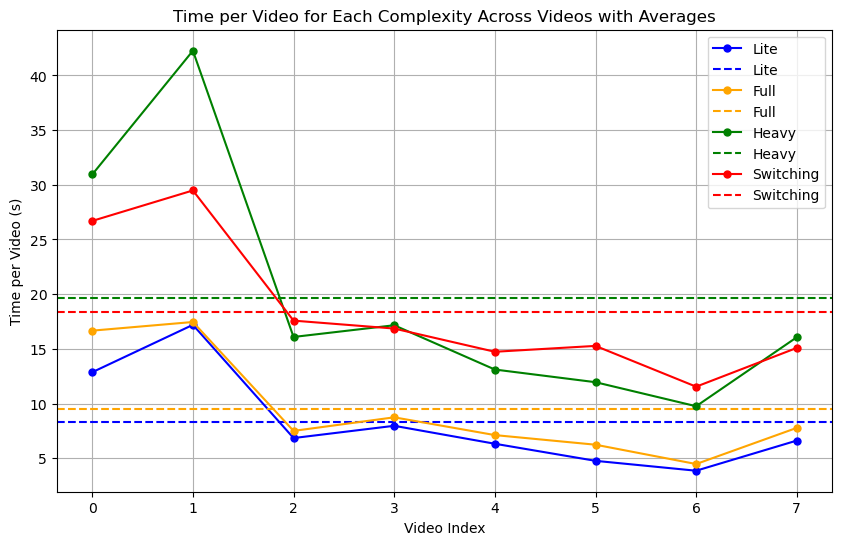

In [6]:
# Directory containing the result folders
root_dir = "./data/result"

complexity_times_per_frame = {0: [], 1: [], 2: [], 3:[]}
# Traverse all folders and read time.json files
for folder_name in os.listdir(root_dir):
    time_json_path = os.path.join(root_dir, folder_name, "time.json")
    if os.path.exists(time_json_path):
        with open(time_json_path, 'r') as f:
            data = json.load(f)
            for i in range(4):
                if i!=3 and data["frame"] > 0:  # Avoid division by zero or negative frames
                    time_per_frame = data[str(i)] 
                if i==3 :
                    time_per_frame = sum(data["1-2"])
                complexity_times_per_frame[i].append(time_per_frame)
# Calculate the average time per frame for each complexity
average_times_per_frame = {
    i: np.mean(complexity_times_per_frame[i]) for i in range(4)
}

# Plotting the time per frame for each complexity as line graphs
plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green', 'red']
labels = ["Lite", "Full", "Heavy", "Switching"]
for i in range(4):
    # Plot individual time per frame data
    plt.plot(
        range(len(complexity_times_per_frame[i])),
        complexity_times_per_frame[i],
        marker='o', linestyle='-', markersize=5,
        color=colors[i],
        label=labels[i]
    )
    # Plot average line
    plt.axhline(
        y=average_times_per_frame[i],
        color=colors[i],
        linestyle='--',
        label=labels[i]
    )

plt.xlabel('Video Index')
plt.ylabel('Time per Video (s)')
plt.title('Time per Video for Each Complexity Across Videos with Averages')
plt.legend()
plt.grid(True)
plt.show()

gt(golfdb)에서 일반적인 영상에서 address~finish는 전체 영상 대비
몇%의 frame을 가지는가

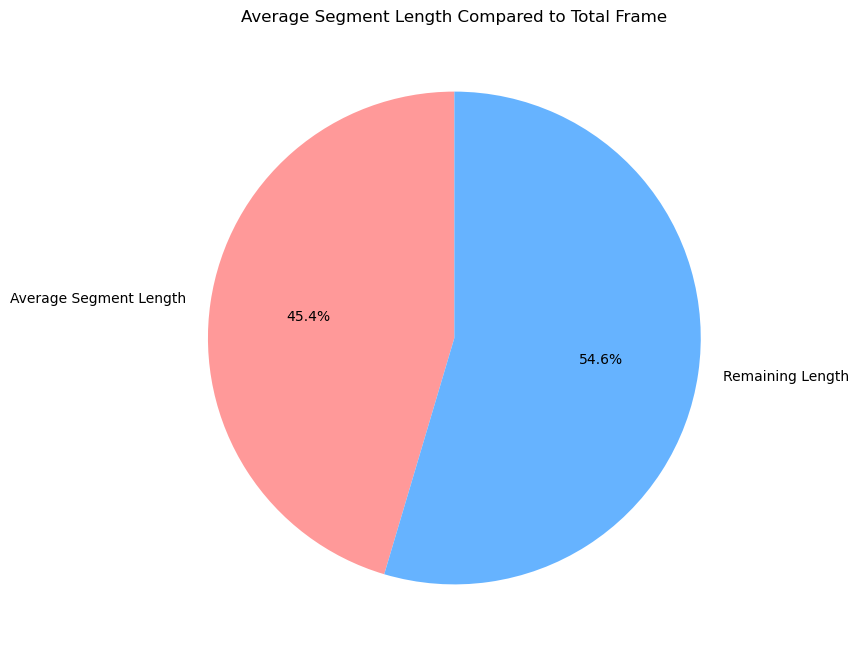

In [41]:
import ast
csv_dir = "./data/ground_truth/GolfDB.csv"

df = pd.read_csv(csv_dir)

# Extract only the 'events' column
events = df['events']

# Initialize variables to calculate total frame differences and segment lengths
total_frame_differences = []
segment_lengths = []

# Process each row in the 'events' column
for events_str in events:
    # Convert string representation of list to an actual list
    events = ast.literal_eval(events_str)
    
    # Calculate total frame and segment length
    total_frame = events[-1] - events[0]
    segment_length = events[-2] - events[1]
    
    if total_frame > 0:
        total_frame_differences.append(total_frame)
        segment_lengths.append(segment_length)

# Calculate the average total frame and average segment length
average_total_frame = sum(total_frame_differences) / len(total_frame_differences)
average_segment_length = sum(segment_lengths) / len(segment_lengths)

# Calculate the ratio of average segment length to average total frame
average_ratio = average_segment_length / average_total_frame

# Visualize the average ratio as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    [average_ratio, 1 - average_ratio],
    labels=["Average Segment Length", "Remaining Length"],
    autopct="%1.1f%%",
    startangle=90,
    colors=["#ff9999", "#66b3ff"]
)
plt.title("Average Segment Length Compared to Total Frame")
plt.show()

Sequencing Accuracy based golfDB Dataset

correct : [0, 0, 1, 0, 0, 1, 1, 1], accuracy : [0.0, 0.0, 100.0, 0.0, 0.0, 100.0, 100.0, 100.0], pce: 100.0
remaining video : 85
correct : [1, 1, 2, 1, 1, 2, 2, 2], accuracy : [50.0, 50.0, 100.0, 50.0, 50.0, 100.0, 100.0, 100.0], pce: 100.0
remaining video : 84
correct : [1, 1, 2, 1, 1, 2, 2, 2], accuracy : [50.0, 50.0, 100.0, 50.0, 50.0, 100.0, 100.0, 100.0], pce: 66.66666666666666
remaining video : 83
correct : [2, 2, 3, 2, 2, 3, 3, 2], accuracy : [66.66666666666667, 66.66666666666667, 100.0, 66.66666666666667, 66.66666666666667, 100.0, 100.0, 66.66666666666667], pce: 75.0
remaining video : 82
correct : [3, 3, 4, 3, 3, 4, 4, 3], accuracy : [75.0, 75.0, 100.0, 75.0, 75.0, 100.0, 100.0, 75.0], pce: 80.0
remaining video : 81
correct : [3, 3, 4, 3, 3, 4, 4, 3], accuracy : [75.0, 75.0, 100.0, 75.0, 75.0, 100.0, 100.0, 75.0], pce: 66.66666666666666
remaining video : 80
correct : [4, 4, 5, 3, 4, 5, 5, 4], accuracy : [80.0, 80.0, 100.0, 60.0, 80.0, 100.0, 100.0, 80.0], pce: 71.42857142857143

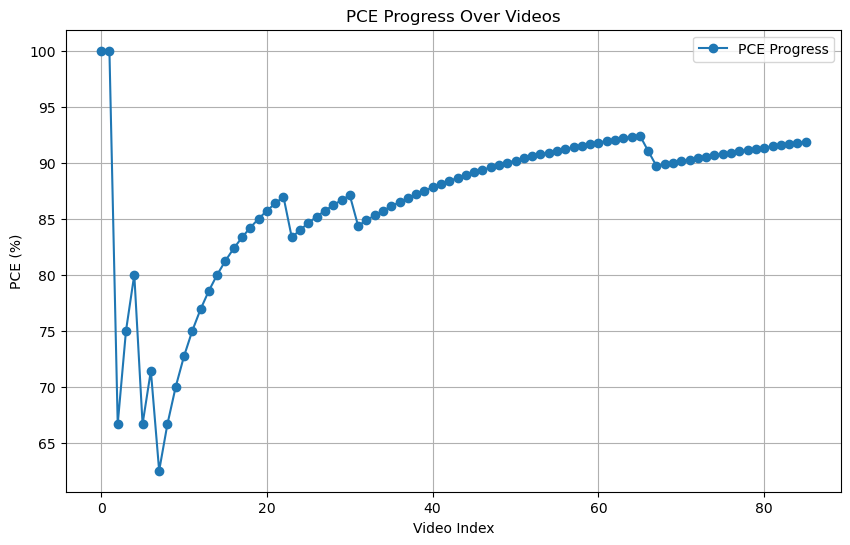

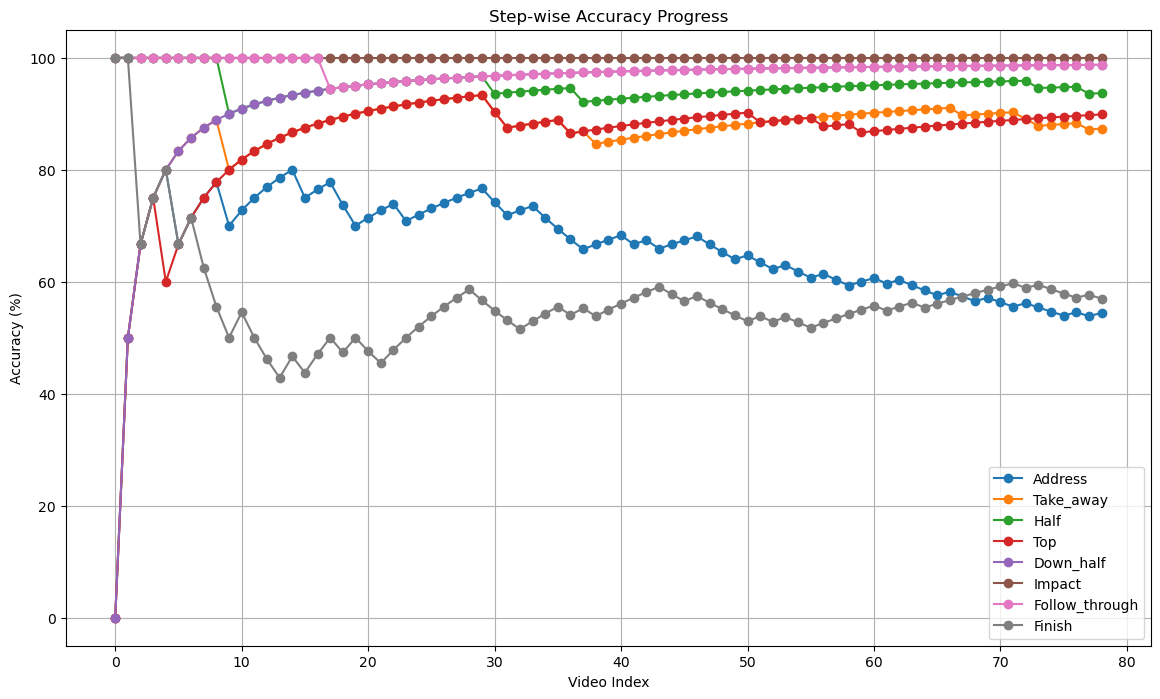

In [ ]:
from tsmoothie.smoother import *
import ast
key_point_string = ["head","right_shoulder","left_shoulder",
                    "right_elbow","left_elbow","right_wrist","left_wrist",
                    "right_hip","left_hip","right_knee","left_knee",
                    "right_ankle", "left_ankle"]

string_match_index = [8,12,11,
                      14,13,16,15,
                      24,23,26,25,
                      32,31]

num_joint = len(key_point_string)
eight_step = ["address", "take_away", "half", "top", "down_half", "impact", "follow_through", "finish" ]

# 이미지 처리 함수
def compelxity_mp_on_video(complexity, video_path):
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
        model_complexity=complexity
    )

    none_frame = []
    cvPoseLandMark = [[[], [], [], []] for _ in range(len(string_match_index))]
    cap = cv2.VideoCapture(video_path)
    fps: float = cap.get(cv2.CAP_PROP_FPS)

    frame: int = 0
    while cap.isOpened():
        success, image = cap.read()
        if not success : break
        if frame==0 : 
            h:int; w:int; c:int 
            h,w,c = image.shape

        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.pose_landmarks == None : 
            for i in range(num_joint) :
                for j in range(0,4) : cvPoseLandMark[i][j].append(0)
            none_frame.append(frame)
        else :
            for i in range(num_joint) :
                cvPoseLandMark[i][0].append(results.pose_landmarks.landmark[string_match_index[i]].x *w)
                cvPoseLandMark[i][1].append(results.pose_landmarks.landmark[string_match_index[i]].y *h)
                cvPoseLandMark[i][2].append(results.pose_world_landmarks.landmark[string_match_index[i]].z)
                cvPoseLandMark[i][3].append(results.pose_world_landmarks.landmark[string_match_index[i]].x)
        frame+=1
    cap.release()
    return cvPoseLandMark, none_frame, frame, w, h,fps

def conv_smoothing(video_length: int, PoseLandmark: list[list[list[float]]], cvPoseLandmark: list[list[list[float]]], 
                   width: int, height: int, empty_frame: list[int]) -> None:
    """
    비디오의 포즈 랜드마크 좌표에 대해 컨볼루션 스무딩을 적용.

    Args:
        video_length (int): 전체 비디오의 길이 (프레임 수).
        PoseLandmark (list[list[list[float]]]): 각 관절의 포즈 랜드마크 좌표를 담고 있는 리스트.
        cvPoseLandmark (list[list[list[float]]]): 각 프레임에서의 포즈 랜드마크 좌표를 담고 있는 리스트.
        width (int): 비디오의 폭 (픽셀).
        height (int): 비디오의 높이 (픽셀).
        empty_frame (list[int]): 포즈 랜드마크를 감지하지 못한 프레임 번호 리스트.

    Returns:
        None
    """
    smoother = ConvolutionSmoother(window_len=3, window_type='ones')
    for joint in range(num_joint):
        # if key_point_string[joint] == "left_shoulder" or key_point_string[joint] == "right_shoulder" :
        #     continue
        smoother.smooth(cvPoseLandmark[joint][0])
        low, up = smoother.get_intervals('sigma_interval',n_sigma=3)
        cvPoseLandmark[joint][0] = smoother.smooth_data[0]

        smoother.smooth(cvPoseLandmark[joint][1])
        low, up = smoother.get_intervals('sigma_interval',n_sigma=3)
        cvPoseLandmark[joint][1] = smoother.smooth_data[0]

        smoother.smooth(cvPoseLandmark[joint][2])
        low, up = smoother.get_intervals('sigma_interval',n_sigma=3)
        cvPoseLandmark[joint][2] = smoother.smooth_data[0]

        smoother.smooth(cvPoseLandmark[joint][3])
        low, up = smoother.get_intervals('sigma_interval',n_sigma=3)
        cvPoseLandmark[joint][3] = smoother.smooth_data[0]

    for frame_num in range(video_length):
        for joint in range(num_joint):
            if frame_num not in empty_frame :
                PoseLandmark[joint][0].append(cvPoseLandmark[joint][0][frame_num]/width)
                PoseLandmark[joint][1].append(cvPoseLandmark[joint][1][frame_num]/height)
                PoseLandmark[joint][2].append(cvPoseLandmark[joint][2][frame_num])
                PoseLandmark[joint][3].append(cvPoseLandmark[joint][3][frame_num])
            else :
                for j in range(4) :
                    PoseLandmark[joint][j].append(0)


def get_index_mp(joint_name: str) -> int:
    """
    주어진 관절 이름에 대한 mediapipe 인덱스를 반환.

    Args:
        joint_name (str): 관절 이름.

    Returns:
        int: mediapipe 관절 인덱스.
    """
    return string_match_index[key_point_string.index(joint_name)]

def get_index_list(joint_name: str) -> int:
    """
    주어진 관절 이름에 대한 리스트 인덱스를 반환.

    Args:
        joint_name (str): 관절 이름.

    Returns:
        int: 리스트 관절 인덱스.
    """
    return key_point_string.index(joint_name)

def get_index_eight(step_name: str) -> int:
    """
    주어진 골프 스윙 8단계 이름에 대한 인덱스를 반환.

    Args:
        step_name (str): 골프 스윙 8단계 이름.

    Returns:
        int: 골프 스윙 8단계 인덱스.
    """
    return eight_step.index(step_name)

def get_step(video_length: int, PoseLandmark: list[list[list[float]]]) -> list[int]:
    """
    골프 스윙의 8단계 프레임을 판별.

    Args:
        video_length (int): 전체 비디오의 길이 (프레임 수).
        PoseLandmark (list[list[list[float]]]): 각 관절의 포즈 랜드마크 좌표를 담고 있는 리스트.

    Returns:
        list[int]: 골프 스윙의 8단계에 해당하는 프레임 번호 리스트.
    """
    
    state = -1 # 8 step을 구분하기 위한 state
    step_frame=[0] * len(eight_step)

    for frame in range(2,video_length): #전체 frame 수에 맞춰 7 단계 구분
        if (PoseLandmark[0][0][frame])==0 : continue

        if state == -1 : state = state + 1

        elif state == 0 : # 사람이 정적임을 판단(들어오고 있는경우를 거름)
            diff_right_wrist = [max(PoseLandmark[get_index_list("right_wrist")][0][frame-2:frame+1]) - min(PoseLandmark[get_index_list("right_wrist")][0][frame-2:frame+1]),
                                max(PoseLandmark[get_index_list("right_wrist")][1][frame-2:frame+1]) - min(PoseLandmark[get_index_list("right_wrist")][1][frame-2:frame+1])]
            diff_right_shoulder = [max(PoseLandmark[get_index_list("right_shoulder")][0][frame-2:frame+1]) - min(PoseLandmark[get_index_list("right_shoulder")][0][frame-2:frame+1]),
                                    max(PoseLandmark[get_index_list("right_shoulder")][1][frame-2:frame+1]) - min(PoseLandmark[get_index_list("right_shoulder")][1][frame-2:frame+1]) ]

            if all(x <= 0.03 for x in diff_right_wrist[:2] + diff_right_shoulder[:2]) : 
                step_frame[get_index_eight("address")] = frame
                state+=1

        elif state == 1: # 테이크어웨이
            if PoseLandmark[get_index_list("left_hip")][1][frame] >= PoseLandmark[get_index_list("right_wrist")][1][frame] and \
                PoseLandmark[get_index_list("right_hip")][1][frame] >= PoseLandmark[get_index_list("right_wrist")][1][frame] :
                step_frame[get_index_eight("take_away")] = frame
                state+=1
                # for adFrame in range(frame,4-1,-1) :
                #     wrist = [ PoseLandmark[get_index_list("right_wrist")][0][adFrame-2:adFrame+1],  PoseLandmark[get_index_list("right_wrist")][1][adFrame-2:adFrame+1] ]
                #     wrist_max_diff = [ max(abs(a - b) for a, b in itertools.combinations(axis_data, 2)) for axis_data in wrist ]

                #     shoulder = [ PoseLandmark[get_index_list("right_shoulder")][0][adFrame-2:adFrame+1],  PoseLandmark[get_index_list("right_shoulder")][1][adFrame-2:adFrame+1] ]
                #     shoulder_max_diff = [ max(abs(a - b) for a, b in itertools.combinations(axis_data, 2)) for axis_data in shoulder ]
    
                #     if all(diff <= 0.0018 for joint_diff in [wrist_max_diff, shoulder_max_diff] for diff in joint_diff) :
                #         if PoseLandmark[get_index_list("right_knee")][0][adFrame-1] < PoseLandmark[get_index_list("right_wrist")][0][adFrame-1] and \
                #             PoseLandmark[get_index_list("right_knee")][0][adFrame-1] < PoseLandmark[get_index_list("right_shoulder")][0][adFrame-1] and \
                #             PoseLandmark[get_index_list("right_shoulder")][1][adFrame-1] < PoseLandmark[get_index_list("right_wrist")][1][adFrame-1] and \
                #             PoseLandmark[get_index_list("left_hip")][1][frame] <= PoseLandmark[get_index_list("right_wrist")][1][frame]:
                #             step_frame[get_index_eight("address")] = adFrame-1
                #             print(step_frame[get_index_eight("address")])
                #             break

        elif state == 2: # 하프
            step_frame[get_index_eight("half")] = frame
            shoulder_y = max(PoseLandmark[get_index_list("left_shoulder")][1][frame],PoseLandmark[get_index_list("right_shoulder")][1][frame])
            y_values = [PoseLandmark[get_index_list("right_wrist")][1][frame], PoseLandmark[get_index_list("left_wrist")][1][frame],
                        PoseLandmark[get_index_list("right_elbow")][1][frame], PoseLandmark[get_index_list("left_elbow")][1][frame]]
            if sum(y <= shoulder_y for y in y_values) >= 2: state += 1

        elif state == 3:  # 탑
            if PoseLandmark[get_index_list("right_wrist")][1][frame] <= PoseLandmark[get_index_list("right_wrist")][1][frame-1] : 
                continue  
            else : 
                step_frame[get_index_eight("top")] = frame-1
                add_to_top_wrist =  PoseLandmark[get_index_list("right_wrist")][1][step_frame[get_index_eight("address")]:step_frame[get_index_eight("top")]+1]

                status = ["up" if add_to_top_wrist[i] >= add_to_top_wrist[i+1] else "down" for i in range(len(add_to_top_wrist)-1)]
                if "down" in status:
                    for reverse_frame in range(len(status)-1,0-1,-1) : 
                        if status[reverse_frame] == "down" :
                            #address 다시잡기
                            step_frame[get_index_eight("address")] = max(step_frame[get_index_eight("address")]+(reverse_frame)-3,0)
                            state_tmp=0
                            for new_search in range(step_frame[get_index_eight("address")], step_frame[get_index_eight("top")]) :
                                if state_tmp==0 : #takeaway 다시잡기
                                    if PoseLandmark[get_index_list("left_hip")][1][new_search] >= PoseLandmark[get_index_list("right_wrist")][1][new_search] and \
                                        PoseLandmark[get_index_list("right_hip")][1][new_search] >= PoseLandmark[get_index_list("right_wrist")][1][new_search] :
                                        step_frame[get_index_eight("take_away")] = new_search
                                        state_tmp+=1
                                elif state_tmp == 1 : #half 다시잡기
                                    step_frame[get_index_eight("half")] = new_search
                                    shoulder_y = max(PoseLandmark[get_index_list("left_shoulder")][1][new_search],PoseLandmark[get_index_list("right_shoulder")][1][new_search])
                                    y_values = [PoseLandmark[get_index_list("right_wrist")][1][new_search], PoseLandmark[get_index_list("left_wrist")][1][new_search],
                                                PoseLandmark[get_index_list("right_elbow")][1][new_search], PoseLandmark[get_index_list("left_elbow")][1][new_search]]
                                    if sum(y <= shoulder_y for y in y_values) >= 2: break
                            break
                state+=1
        elif state == 4: # 임팩트
            takeaway_to_top_length = (step_frame[get_index_eight("top")]-step_frame[get_index_eight("take_away")])
            wrist_y = PoseLandmark[get_index_list("right_wrist")][1][frame:frame+takeaway_to_top_length]
            if wrist_y[0] == max(wrist_y) : step_frame[get_index_eight("impact")] = frame ; state+=1; 

        elif state == 5: # 팔로우스루
            shoulder = (PoseLandmark[get_index_list("left_shoulder")][1][frame] + PoseLandmark[get_index_list("right_shoulder")][1][frame])/2
            hip = (PoseLandmark[get_index_list("left_hip")][1][frame] + PoseLandmark[get_index_list("right_hip")][1][frame])/2
            base_y = (hip - abs(shoulder-hip)/3)
            if base_y <= PoseLandmark[get_index_list("right_wrist")][1][frame] : pass
            else : step_frame[get_index_eight("follow_through")] = frame; state += 1

        elif state == 6: #finish
            wrist_y = [PoseLandmark[get_index_list("right_wrist")][1][frame] for frame in \
            range(step_frame[get_index_eight("follow_through")], min(step_frame[get_index_eight("follow_through")]+((step_frame[get_index_eight("follow_through")]-step_frame[get_index_eight("top")])*2),video_length))]
            finish_idx = (wrist_y.index(min(wrist_y))+step_frame[get_index_eight("follow_through")])
            step_frame[get_index_eight("finish")] = finish_idx
            for idx_frame in range(step_frame[get_index_eight("finish")], video_length) :
                wrist_y = PoseLandmark[get_index_list("left_wrist")][1][idx_frame]
                threshold = (PoseLandmark[get_index_list("left_shoulder")][1][step_frame[get_index_eight("finish")]] + \
                            PoseLandmark[get_index_list("left_wrist")][1][step_frame[get_index_eight("finish")]])/2
                if threshold>=wrist_y : 
                    step_frame[get_index_eight("finish")] = idx_frame
                    break

            #down half
            down_wrist_y = PoseLandmark[get_index_list("right_wrist")][1][step_frame[get_index_eight("top")]:step_frame[get_index_eight("impact")]]
            down_shoulder_y = PoseLandmark[get_index_list("left_shoulder")][1][step_frame[get_index_eight("top")]:step_frame[get_index_eight("impact")]]
            for down_frame in range(len(down_wrist_y)) :
                if down_wrist_y[down_frame] >= down_shoulder_y[down_frame] :
                    step_frame[get_index_eight("down_half")] = down_frame + step_frame[get_index_eight("top")]
                    break
            break

            # wrist = [ b[get_index_list("left_wrist")][0][frame-3:frame+1],  b[get_index_list("left_wrist")][1][frame-3:frame+1] ]
            # wrist_max_diff = [ max(abs(a - b) for a, b in itertools.combinations(axis_data, 2)) for axis_data in wrist ]
            # if all(data < 0.005 for data in wrist_max_diff): step_frame[6] = frame; break
            # if frame==a-1 : step_frame[6]=0; break
    return step_frame

# Reading the CSV content
df = pd.read_csv("./data/ground_truth/golfDB/GolfDB.csv")
id_events_df = df[['id', 'events']]
#print(id_events_df.loc[id_events_df['id'] == 0, 'events'].values[0])

gt_video_path = "./data/ground_truth/golfDB/videos"
video_files = [file for file in os.listdir(gt_video_path) if file.endswith('.mp4')]

pce_cnt = 0
pce_decnt = 0
correct_cnt = [0]* len(eight_step)
run_cnt=0
run_video = 0
pce_log = []
accuracy_log=[]

for video_name in video_files :
    flag=0
    run_video +=1
    gt_events = id_events_df.loc[id_events_df['id'] == int(video_name.split('.mp4')[0]), 'events'].values[0]
    gt_events = ast.literal_eval(gt_events)
    video_path = gt_video_path +"/"+video_name
    PoseLandMark: list[list[list[float]]] = [[[], [], [],[]] for _ in range(len(string_match_index))] # poseLandmark[joint][axis][frame]
    
    cv, none_frame, frame, w, h,fps=compelxity_mp_on_video(1,video_path)
    conv_smoothing(frame,PoseLandMark,cv,w,h, none_frame)

    step_frame: list[int] = get_step(frame, PoseLandMark)
    
    #accuracy
    if 0 in step_frame[1:] or len(step_frame) != len(set(step_frame)) or abs(step_frame[get_index_eight("top")]-step_frame[get_index_eight("impact")])<2:
        pce_decnt+=1
    else : 
        pce_cnt +=1
        flag=1
    pce = pce_cnt/run_video * 100
    pce_log.append(pce)

    add_to_impact = int(gt_events[6])-int(gt_events[1])
    delta = max(round(add_to_impact/fps), 1)
    run_cnt+=1

    if flag==1 :
        for index, sequence in enumerate(step_frame):
            if abs(sequence-int(gt_events[1+index]))<=delta : 
                    correct_cnt[index] +=1
        accuracy = [x*100/(run_video-pce_decnt) for x in correct_cnt]
        accuracy_log.append(accuracy)
    print(f"correct : {correct_cnt}, accuracy : {accuracy}, pce: {np.mean(pce)}")
    print(f"remaining video : {len(video_files)-run_cnt}")

# Plotting the PCE progress and its average
plt.figure(figsize=(10, 6))
plt.plot(pce_log, marker='o', label="PCE Progress")
plt.title("PCE Progress Over Videos")
plt.xlabel("Video Index")
plt.ylabel("PCE (%)")
plt.legend()
plt.grid(True)
plt.show()

accuracy_log = np.array(accuracy_log).T  # Transpose to access [step][video_index]

plt.figure(figsize=(14, 8))

for step_index, step_name in enumerate(eight_step):
    # Plotting the step's accuracy progress
    plt.plot(
        accuracy_log[step_index], 
        marker='o', 
        label=f"{step_name.capitalize()}"
    )

plt.title("Step-wise Accuracy Progress")
plt.xlabel("Video Index")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

    